#### ***imports***

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from scipy.spatial.distance import euclidean, cityblock, cosine
from collections import Counter, defaultdict

import auxiliarfunctions as af
import knn.knn as neighbors
import numpy as np

#### ***Loading the Datasets***

The datasets used in this notebook are extracted from OpenMl

In [41]:
datasets = []                                        # list of datasets that store tuples X, y
datatraintest = []                                   # list of tuples X_train, X_test, y_train, y_test
    
ids = [37,43465,61,40983,44] #[37,163,40498,187,41,1527,40983] #,1459
datasets_name = ["Diabetes",                         # list of datasets names
                 "Boston-house-price-data",
                 "Iris",
                 "Wilt",
                 "Spambase"
                ]  
#1527 -> Anomaly Detection Meta-Analysis Benchmarks
#1459
#ids = [41]

# Fetch and prepare the datasets
for i in ids:
    datasets.append(af.fetch_and_prepare_dataset(i))

# Append the split of the datasets into train and test
for i in range(len(ids)):
    datatraintest.append(train_test_split(datasets[i][0], datasets[i][1], test_size=0.2))

#### ***Visualização dos datsets***

37


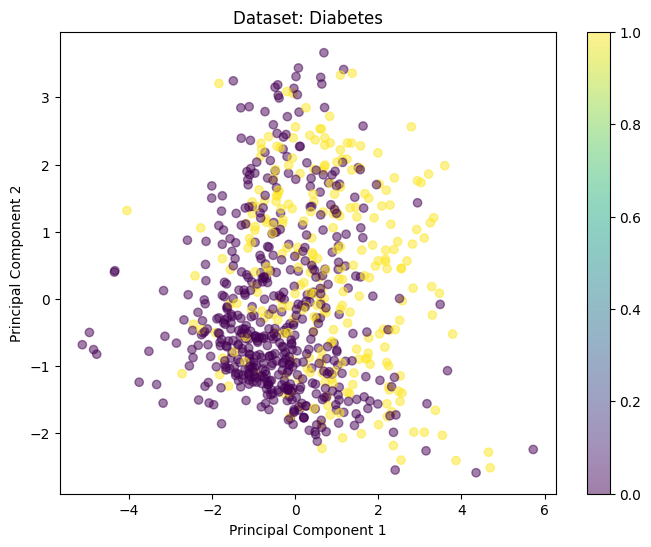

43465


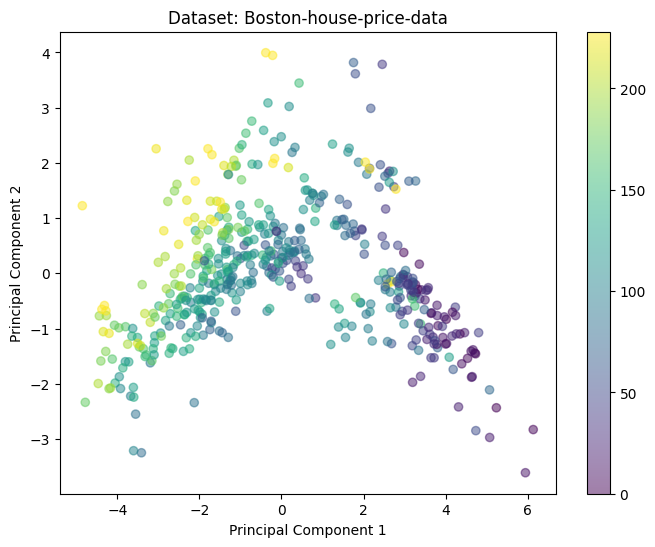

61


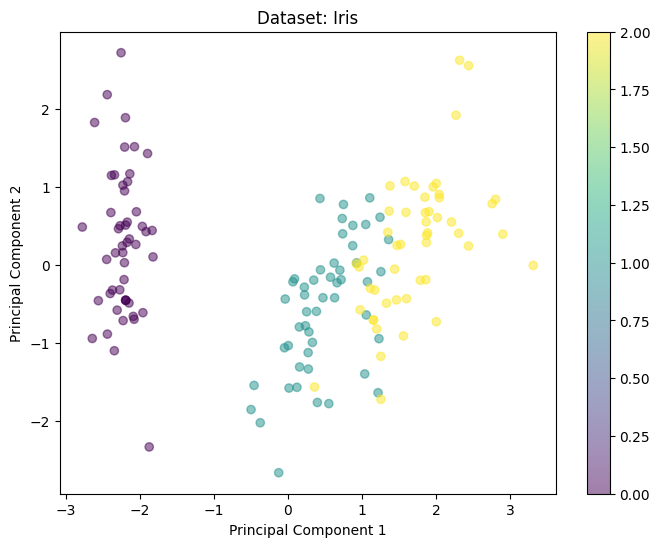

40983


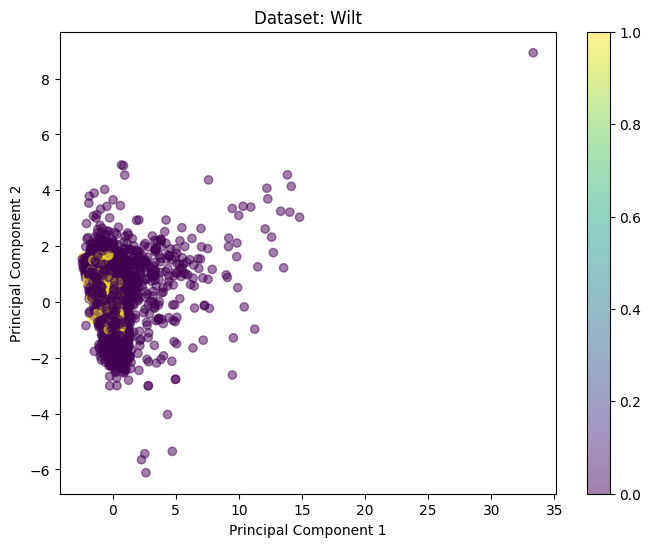

44


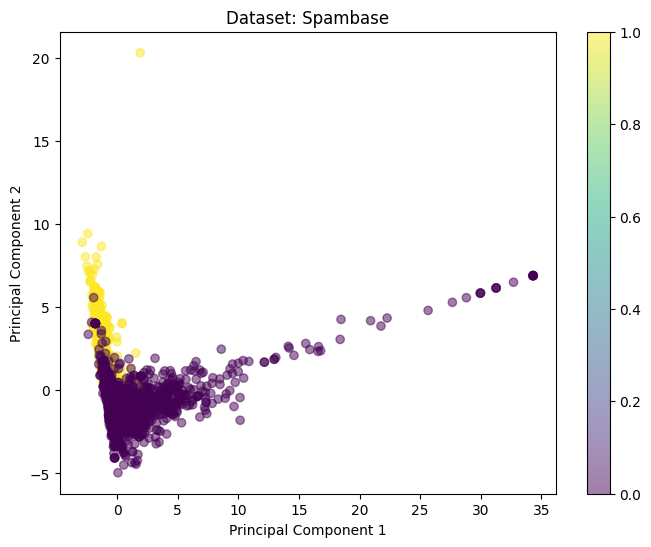

In [42]:
for i in range(len(ids)):
    print(ids[i])
    af.apply_pca_and_plot_with_encoding(datasets[i][0], datasets[i][1],datasets_name[i])

#### ***Modificacoes no KNN***

explicar que comecamos por alterar esta classe par que quando o knn fzesse o fit, podemos calcular os pesos de cada ponto em relacao a ser um aulier ou nao.

In [43]:
class BaseEstimatorModifiedLOF:
    y_required = True
    fit_required = True

    def _setup_input(self, X, y=None):
        """Ensure inputs to an estimator are in the expected format.

        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. Enables estimators to define whether
        they require a set of y target values or not with y_required, e.g.
        kmeans clustering requires no target labels and is fit against only X.

        Parameters
        ----------
        X : array-like
            Feature dataset.
        y : array-like
            Target values. By default is required, but if y_required = false
            then may be omitted.
        """
        #modificaçao

        lof = LocalOutlierFactor(n_neighbors=20)
        # -> [1,-1]
        lof.fit_predict(X) 
        # -> [quando é oulier tem um valor mais pequeno]
        lof_scores_train = lof.negative_outlier_factor_ 
        # -> colocar entre 0 e 1, onde 0 é 100% oulier e 1 é 100% um ponto normal
        self.weigth = (lof_scores_train - min(lof_scores_train)) / (max(lof_scores_train) - min(lof_scores_train))

        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Got an empty matrix.")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")

            if not isinstance(y, np.ndarray):
                y = np.array(y)

            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")

        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

    def _predict(self, X=None):
        raise NotImplementedError()
    

In [44]:
class KNNBase(BaseEstimatorModifiedLOF):
    def __init__(self, k=5, distance_func = None):
        """Base class for Nearest neighbors classifier and regressor.

        Parameters
        ----------
        k : int, default 5
            The number of neighbors to take into account. If 0, all the
            training examples are used.
        distance_func : function, default euclidean distance
            A distance function taking two arguments. Any function from
            scipy.spatial.distance will do.
        """

        self.k = None if k == 0 else k  # l[:None] returns the whole list
        self.distance_func = distance_func
        self.distance = [euclidean, cityblock, cosine]
        

    def aggregate(self):
        raise NotImplementedError()

    def _predict(self, X=None):

        predictions = [self._predict_x(x) for x in X] 

        predictions = [Counter(prediction).most_common(1)[0][0] for prediction in predictions]

        return np.array(predictions)

    def _predict_x(self, x):
        """Predict the label of a single instance x."""
        prediction = []
        if self.distance_func is None:
            for k in self.distance:

                # compute distances between x and all examples in the training set.
                distances = (k(x, example) for example in self.X)

                # Sort all examples by their distance to x and keep their target value.
                neighbors = sorted(((dist, target,weigth) for (dist, target,weigth) in zip(distances, self.y, self.weigth)), key=lambda x: x[0])
                # print("Neighbors with distance:", neighbors[: self.k])
                # Get targets of the k-nn and aggregate them (most common one or
                # average).
                neighbors_targets = [(target,weigth) for (_, target, weigth) in neighbors[: self.k]]
                prediction.append(self.aggregate(neighbors_targets))
        else:
            distances = (self.distance_func(x, example) for example in self.X)

            # Sort all examples by their distance to x and keep their target value.
            neighbors = sorted(((dist, target,weigth) for (dist, target,weigth) in zip(distances, self.y, self.weigth)), key=lambda x: x[0])
            # print("Neighbors with distance:", neighbors[: self.k])
            # Get targets of the k-nn and aggregate them (most common one or
            # average).
            neighbors_targets = [(target,weigth) for (_, target, weigth) in neighbors[: self.k]]
            prediction.append(self.aggregate(neighbors_targets))
        return prediction


class KNNClassifierLOF(KNNBase):
    """Nearest neighbors classifier.

    Note: if there is a tie for the most common label among the neighbors, then
    the predicted label is arbitrary."""

    def aggregate(self, neighbors_targets):
        """Return the most common target label."""
        size = len(neighbors_targets)
        n = size
        weighted_dict = defaultdict(float)

        for target, weight in neighbors_targets:
            weighted_dict[target] += ((n*weight)/size)
            n -=1
            
        weighted_dict = dict(weighted_dict)

        max_target = max(weighted_dict.items(), key=lambda item: item[1])
        
        max_target_key, _ = max_target

        return max_target_key

#### ***Classification***


The classification is done using the KNN algorithm, we still used the unmofied version of the algorithm to classify the data so we can have a baseline to compare the results with. 

In [45]:
# list of classifiers
classifiers = [neighbors.KNNClassifier(k=5), KNNClassifierLOF(k=5), ] # , neighbors_modified.KNNClassifier(k=5)
classifiers_names = ['KNN', 'KNN Modified']

In [46]:
def classify_and_evaluate(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    return accuracy_score(y_test, y_pred)

#### ***Results***

##### ***Dataset Diabetes -> id: 37***

In [47]:
for i in range(len(datasets)):
    for classifier, classifier_name in zip(classifiers, classifiers_names):
        X_train, X_test, y_train, y_test = datatraintest[i]
        accuracy = classify_and_evaluate(classifier, X_train, X_test, y_train, y_test)
        print(f'Accuracy for dataset {datasets_name[i]} with classifier {classifier_name}: {accuracy}')

Accuracy for dataset Diabetes with classifier KNN: 0.6753246753246753
Accuracy for dataset Diabetes with classifier KNN Modified: 0.6818181818181818
Accuracy for dataset Boston-house-price-data with classifier KNN: 0.0196078431372549
Accuracy for dataset Boston-house-price-data with classifier KNN Modified: 0.029411764705882353
Accuracy for dataset Iris with classifier KNN: 1.0
Accuracy for dataset Iris with classifier KNN Modified: 1.0
Accuracy for dataset Wilt with classifier KNN: 0.9762396694214877
Accuracy for dataset Wilt with classifier KNN Modified: 0.9824380165289256
Accuracy for dataset Spambase with classifier KNN: 0.7958740499457112
Accuracy for dataset Spambase with classifier KNN Modified: 0.8523344191096635


In [48]:
from sklearn.datasets import load_breast_cancer

 
data = load_breast_cancer(as_frame=True).data
iso = IsolationForest(contamination=0.1)
outliers = iso.fit_predict(data)
data["ISO"] = outliers
print(outliers)
outliers = iso.fit(data)

[-1  1  1 -1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1
  1  1  1  1  1 -1 -1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1 -1  1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1  1  1  1  1 -1  1
 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1 -1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1

In [49]:
weigt = outliers.score_samples(data)
print(weigt)
weigt = (weigt - min(weigt))/ ( max(weigt) - min(weigt))
print(weigt)

[-0.55926261 -0.43679145 -0.43695953 -0.63885926 -0.45643479 -0.44292601
 -0.40136605 -0.40392951 -0.43657464 -0.56976381 -0.41948397 -0.3906773
 -0.5993457  -0.40405386 -0.47001318 -0.45596344 -0.38731778 -0.41398183
 -0.46865143 -0.37323398 -0.37632949 -0.40087511 -0.49264916 -0.47532124
 -0.44280549 -0.51519157 -0.43918346 -0.43094453 -0.42220838 -0.38569916
 -0.43049402 -0.45729142 -0.42356216 -0.44846989 -0.42960692 -0.40900632
 -0.38093789 -0.415572   -0.51427634 -0.39524863 -0.38281998 -0.41889678
 -0.56330066 -0.38171949 -0.39958495 -0.43419026 -0.43278294 -0.4062069
 -0.36871981 -0.37602267 -0.38218068 -0.38798824 -0.36768731 -0.43430395
 -0.38671555 -0.37935201 -0.42873059 -0.39553689 -0.41580113 -0.45898044
 -0.44239676 -0.4375657  -0.44857844 -0.46881435 -0.39027477 -0.38877079
 -0.40448036 -0.38375086 -0.59689378 -0.37907073 -0.44073681 -0.53301576
 -0.45001728 -0.37403916 -0.35886883 -0.41638328 -0.42301074 -0.49132729
 -0.62059599 -0.35631809 -0.38660834 -0.38091404 -0.5